In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.pyplot as plt
from pandas.core.reshape.api import merge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from bayes_opt import BayesianOptimization



Create  a dataframe with season, player,pos, age, experience, tm, g, mp, drb_percent, stl_percent, blk_percent, dws, dbpm from Advanced.csv, share, player, season from Player Award Shares.csv, w, l, abbreviation, season, d_rtg from Team Summaries.csv


In [2]:
seasons = ['2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', 
           '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002',
           '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983']

Data Preprocessing

In [3]:

# Creates Dataframes
voting = pd.read_csv("Player Award Shares.csv")
advanced = pd.read_csv("Advanced.csv")
team_data = pd.read_csv("Team Summaries.csv")

# Delete non-DPOY voting
voting = voting[voting['award'] == "dpoy"]

# Deletes all data that is before the DPOY award was introduced
advanced = advanced[advanced['season'] >= 1983]
team_data = team_data[team_data['season'] >= 1983]

# Delete all non-important columns
columns_kept = ["season", "player", "age", "experience", "tm", "g", "mp", "drb_percent", "stl_percent", "blk_percent", "dws","dbpm"]
advanced = advanced[columns_kept]

columns_kept = ["season", "player", "share", "tm"]
voting = voting[columns_kept]

columns_kept = ["season", "abbreviation", "w", "l","d_rtg"]
team_data = team_data[columns_kept]

# Get rid of players who were traded mid-season and the 2001 and 2023 season
voting = voting[voting["season"] != 2001]
advanced = advanced[advanced["season"] != 2001]
team_data = team_data[team_data["season"] != 2001]

voting = voting[voting["season"] != 2023]
advanced = advanced[advanced["season"] != 2023]
team_data = team_data[team_data["season"] != 2023]

advanced = advanced.drop_duplicates(subset=['player', 'season'], keep= False)
voting = voting[voting['tm'] != "TOT"]

# Use league average d_rtg - the teams d_rtg instead of just d_rtg and use W/L percent
team_data['W/L_percent'] = team_data['w'] / (team_data['l'] + team_data['w'])
team_data = team_data.drop(['w', 'l'], axis=1)

# create a new dataframe with valid abbreviation values
team_data_clean = team_data.dropna(subset=["abbreviation"])

# compute the average defense rating for the season
season_avg = team_data_clean.groupby("season")["d_rtg"].mean().reset_index()

# merge the team_data_clean and season_avg dataframes
merged_data = pd.merge(team_data_clean, season_avg, on="season", suffixes=("_team", "_season"))

# compute the defense rating difference for each team
merged_data["d_rtg_diff"] = merged_data["d_rtg_team"] - merged_data["d_rtg_season"]

#merge files on player and season
merged_data = merged_data.drop('d_rtg_team', axis=1)
merged_data = merged_data.drop('d_rtg_season', axis=1)

merged_data = merged_data.rename(columns={'abbreviation': 'tm'})
merged_df = pd.merge(advanced, merged_data, on=['tm', 'season'], how="outer")

voting = voting.drop("tm", axis = 1)
final_merged_df = pd.merge(merged_df, voting, on=['player', 'season'], how="outer")

final_merged_df["share"] = final_merged_df["share"].fillna(0)
final_merged_df = final_merged_df[~final_merged_df[['drb_percent', 'blk_percent', 'stl_percent']].isna().any(axis=1)].reset_index(drop=True)

final_merged_df = final_merged_df[final_merged_df["mp"] >= 1500]



In [4]:
final_merged_df

,season,player,age,experience,tm,g,mp,drb_percent,stl_percent,blk_percent,dws,dbpm,W/L_percent,d_rtg_diff,share
0,2022,Aaron Gordon,26.0,8,DEN,75,2376.0,14.3,0.9,1.7,2.0,-1.1,0.585366,0.150000,0.0
7,2022,Jeff Green,35.0,14,DEN,75,1849.0,11.1,0.7,1.3,1.2,-1.3,0.585366,0.150000,0.0
10,2022,Monte Morris,26.0,5,DEN,75,2239.0,9.6,1.2,0.6,1.5,-0.8,0.585366,0.150000,0.0
11,2022,Nikola Jokić,26.0,7,DEN,74,2476.0,35.5,2.2,2.3,4.5,4.5,0.585366,0.150000,0.0
15,2022,Will Barton,31.0,10,DEN,71,2277.0,14.1,1.2,1.2,1.9,-0.9,0.585366,0.150000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15014,1983,Mark Olberding,26.0,8,CHI,80,1817.0,14.7,1.2,0.3,1.0,-0.8,0.341463,3.308696,0.0
15016,1983,Orlando Woolridge,23.0,2,CHI,57,1627.0,11.6,1.1,1.4,0.8,-1.1,0.341463,3.308696,0.0
15017,1983,Quintin Dailey,22.0,1,CHI,76,2081.0,8.9,1.6,0.3,0.9,-1.4,0.341463,3.308696,0.0
15018,1983,Reggie Theus,25.0,5,CHI,82,2856.0,7.8,2.3,0.3,1.6,-1.0,0.341463,3.308696,0.0


In [5]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6269 entries, 0 to 15019
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       6269 non-null   int64  
 1   player       6269 non-null   object 
 2   age          6269 non-null   float64
 3   experience   6269 non-null   int64  
 4   tm           6269 non-null   object 
 5   g            6269 non-null   int64  
 6   mp           6269 non-null   float64
 7   drb_percent  6269 non-null   float64
 8   stl_percent  6269 non-null   float64
 9   blk_percent  6269 non-null   float64
 10  dws          6269 non-null   float64
 11  dbpm         6269 non-null   float64
 12  W/L_percent  6269 non-null   float64
 13  d_rtg_diff   6269 non-null   float64
 14  share        6269 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 783.6+ KB


Data Split

In [6]:
def training_testing_split(years, dataframe):

  # Create boolean mask to select rows based on list of years
  year_mask = dataframe['season'].isin(years)

  training_df = dataframe[~year_mask]
  testing_df = dataframe[year_mask]

  training_share = training_df['share']  # New variable to hold the 'share' column
  testing_share = testing_df['share']    # New variable to hold the 'share' column

  training_df = training_df.drop(['player', "season", "tm", "share"], axis=1)
  testing_df = testing_df.drop(['player', "season", "tm", "share"], axis=1)
  # Scale data

  # scaler = MinMaxScaler()
  # training_df = scaler.fit_transform(training_df)
  # testing_df = scaler.transform(testing_df)

  scaler = MaxAbsScaler()
  training_df = scaler.fit_transform(training_df)
  testing_df = scaler.transform(testing_df)

  # scaler = RobustScaler()
  # training_df = scaler.fit_transform(training_df)
  # testing_df = scaler.transform(testing_df)

  # scaler = PowerTransformer()
  # training_df = scaler.fit_transform(training_df)
  # testing_df = scaler.transform(testing_df)

  X_train = training_df
  y_train = training_share

  X_test = testing_df
  y_test = testing_share

  cols = dataframe.columns.drop(['player', "season", "tm", "share"]) # Use original dataframe to get the column names
  cols = np.array(cols)

  return X_train, y_train, X_test, y_test, cols

ML Models

In [7]:
years = [2020,1990,2009,2016]
X_train, y_train, X_test, y_test, cols = training_testing_split(years, final_merged_df)

train_data = pd.DataFrame(X_train, columns=cols)
train_labels = pd.Series(y_train)
test_data = pd.DataFrame(X_test, columns=cols)
test_labels = pd.Series(y_test)

In [8]:

# Create the random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Fit the model to the training data
rf_model.fit(train_data, train_labels)

# Predict the target variable for the test data
predicted_labels = rf_model.predict(test_data)

# Calculate the R^2, MAE, MSE, and MAPE metrics
r2 = r2_score(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)
mse = mean_squared_error(test_labels, predicted_labels)

# Print the results
print(f'R^2 score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

R^2 score: 0.3601
MAE: 0.0111
MSE: 0.0034


In [9]:
# Create the neural network model
nn_model = MLPRegressor()

# Fit the model to the training data
nn_model.fit(train_data, train_labels)

# Predict the target variable for the test data
predicted_labels = nn_model.predict(test_data)

# Calculate the R^2, MAE, MSE metrics
r2 = r2_score(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)
mse = mean_squared_error(test_labels, predicted_labels)

# Print the results
print(f'R^2 score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

R^2 score: 0.3133
MAE: 0.0162
MSE: 0.0037


In [10]:
# Create the SVM model
svm_model = SVR(kernel='poly')

# Fit the model to the training data
svm_model.fit(train_data, train_labels)

# Predict the target variable for the test data
predicted_labels = svm_model.predict(test_data)

# Calculate the R^2, MAE, MSE, metrics
r2 = r2_score(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)
mse = mean_squared_error(test_labels, predicted_labels)
mape = mean_absolute_percentage_error(test_labels, predicted_labels)

# Print the results
print(f'R^2 score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

R^2 score: 0.1018
MAE: 0.0436
MSE: 0.0048


In [11]:
# Create the XGBoost model
# xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model =  xgb.XGBRegressor()
# Fit the model to the training data
xgb_model.fit(train_data, train_labels)

# Predict the target variable for the test data
predicted_labels = xgb_model.predict(test_data)

# Calculate the R^2, MAE, MSE metrics
r2 = r2_score(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)
mse = mean_squared_error(test_labels, predicted_labels)

# Print the results
print(f'R^2 score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

R^2 score: 0.4186
MAE: 0.0123
MSE: 0.0031


In [12]:

# define objective function
def xgb_objective(learning_rate, max_depth, subsample):
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'objective': 'binary:logistic'
    }
    dtrain = xgb.DMatrix(train_data, label=train_labels)
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='auc')
    return cv_result['test-auc-mean'].iloc[-1]

# define parameter bounds
pbounds = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0)
}

# create optimizer
optimizer = BayesianOptimization(f=xgb_objective, pbounds=pbounds, random_state=1)

# optimize
optimizer.maximize(init_points=5, n_iter=20)

# print results
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | subsample |
-------------------------------------------------------------
| 1         | 0.956     | 0.08923   | 8.042     | 0.5001    |
| 2         | 0.9533    | 0.06744   | 4.027     | 0.5462    |
| 3         | 0.9484    | 0.04539   | 5.419     | 0.6984    |
| 4         | 0.9551    | 0.1124    | 5.934     | 0.8426    |
| 5         | 0.9497    | 0.04885   | 9.147     | 0.5137    |
| 6         | 0.9528    | 0.08141   | 8.529     | 0.8872    |
| 7         | 0.9543    | 0.1111    | 8.512     | 0.5874    |
| 8         | 0.9556    | 0.09994   | 8.226     | 0.5238    |
| 9         | 0.9486    | 0.05323   | 4.089     | 0.9737    |
| 10        | 0.9554    | 0.148     | 8.1       | 0.5973    |
| 11        | 0.9553    | 0.169     | 6.446     | 0.9547    |
| 12        | 0.9543    | 0.1915    | 7.648     | 0.7354    |
| 13        | 0.9535    | 0.1029    | 8.888     | 0.9895    |
| 14        | 0.8995    | 0.01      | 6.347     | 0.5       |
| 15    

In [13]:
xgb_model =  xgb.XGBRegressor(learning_rate = 0.1929, max_depth =7, subsample = 0.9822)
# Fit the model to the training data
xgb_model.fit(train_data, train_labels)

# Predict the target variable for the test data
predicted_labels = xgb_model.predict(test_data)

# Calculate the R^2, MAE, MSE metrics
r2 = r2_score(test_labels, predicted_labels)
mae = mean_absolute_error(test_labels, predicted_labels)
mse = mean_squared_error(test_labels, predicted_labels)


# Print the results
print(f'R^2 score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')


R^2 score: 0.4750
MAE: 0.0112
MSE: 0.0028


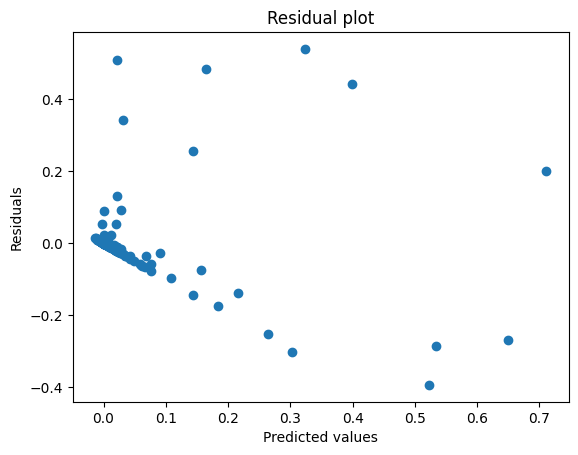

In [14]:
# Compute residuals
residuals = test_labels - predicted_labels

# Plot residual plot
plt.figure()
plt.scatter(predicted_labels, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()


In [15]:
# The data for the top 3 candidates of the 2023 season in order of 'Jaren Jackson Jr.', 'Brook Lopez' and 'Bam Adebayo'
top_3 = [
    [ 23, 5, 63, 1787, 18.8, 1.7, 9.6, 3.8, 2, 0.621951, -3.6],
    [ 34, 15, 78, 2373, 15.3, 0.7, 6.7, 3.9, 1.3, 0.707317, -2.9],
    [ 25, 6, 75, 2598, 23.6, 1.7, 2.4, 3.8, 0.8, 0.536585, -1.5]
]
columns = ['age', 'experience', 'g', 'mp', 'drb_percent', 'stl_percent', 'blk_percent', 'dws', 'dbpm', 'W/L_percent', 'd_rtg_diff']

top_3_contenders = pd.DataFrame(top_3, columns=columns)

predictions = xgb_model.predict(top_3_contenders)
print(predictions)

[0.44527543 0.45104924 0.43956226]
